### Install libraries

In [1]:
!pip install pandas lightning emoji wandb scikit-multilearn datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.5 MB/s eta 0:00:00


In [2]:
# import libraries
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader

# from thaixtransformers import Tokenizer

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
)
import pytorch_lightning as pl
from sklearn.metrics import accuracy_score

# from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
import re
import emoji
import string
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb
from lightning.pytorch.loggers import WandbLogger
from skmultilearn.model_selection import IterativeStratification

import warnings
import os

warnings.filterwarnings("ignore")
os.makedirs("graphs", exist_ok=True)

### Set tunable parameters

In [3]:
PREPROCESS_DATA = True
MAX_COMMENT_LENGTH = 2000
UPSAMPLING_CLASS_3 = 2000
UPSAMPLING_CLASS_5 = 2000
UPSAMPLING_CLASS_8 = 2000
UPSAMPLING_CLASS_11 = 2000
DOWNSAMPLING_CLASS_1_ONLY_PERCENTAGE = 0.4
DOWNSAMPLING_CLASS_6_ONLY_PERCENTAGE = 0.5
DOWNSAMPLING_0_LABEL = 0.6
UPSAMPLING_2_LABEL = 5000
PREDICTION_THRESHOLD = 0.5
TOKENIZER_MAX_LENGTH = 300
BATCH_SIZE = 32
EPOCH = 1
LEARNING_RATE = 5e-5

### Load dataset

In [4]:
dataset_path = "/kaggle/input/2110446-dsde-2024-2/"

df = pd.read_csv(dataset_path + "train.csv")
print(df.shape)

(204622, 14)


### Data preprocess

#### Plot graphs

In [5]:
def plot_class_distribution(df, filename="class_dist.png"):
    label_counts = df.iloc[:, 2:].sum()
    label_counts.plot(kind="bar")
    for i, count in enumerate(label_counts):
        plt.text(
            i,
            count,
            f"{count if count < 1000 else f'{count/1000:.1f}k'}",
            ha="center",
            va="bottom",
        )
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.title("Class Distribution")
    plt.xticks(range(12), range(1, 13))
    plt.savefig(f"/kaggle/working/graphs/{filename}")
    plt.show()
    print("\n")
    return


def plot_label_counts(df, filename="label_counts.png"):
    label_counts = df["label_counts"].value_counts().sort_index()
    label_counts.plot(kind="bar")
    for i, count in label_counts.items():
        plt.text(
            i,
            count,
            f"{count if count < 1000 else f'{count/1000:.1f}k'}",
            ha="center",
            va="bottom",
        )
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.title("Label Counts")
    plt.savefig(f"/kaggle/working/graphs/{filename}")
    plt.show()
    print("\n")
    return


def plot_comment_length(df, bins=20, min_limit=None, max_limit=None):
    plt.figure(figsize=(10, 5))

    df["comment_length"] = df["comment"].apply(len)
    if min_limit is not None:
        df = df[df["comment_length"] > min_limit]
    if max_limit is not None:
        df = df[df["comment_length"] < max_limit]

    min_length = min_limit if min_limit is not None else 0
    max_length = df["comment"].apply(len).max()
    bin_edges = np.arange(min_limit, max_length + bins, bins)

    ax = df["comment_length"].plot(kind="hist", bins=bin_edges)

    for patch in ax.patches:
        height = patch.get_height()
        ax.annotate(
            f"{int(height) if height < 1000 else f'{height/1000:.1f}k'}",
            (patch.get_x() + patch.get_width() / 2, height),
            ha="center",
            va="bottom",
        )

    plt.xlabel("Comment Length")
    plt.ylabel("Frequency")
    length = len(df) if len(df) < 1000 else f"{len(df)/1000:.1f}K"
    plt.title(f"Comment Length Distribution : {length} records")
    plt.xticks(bin_edges, rotation=90)
    plt.show()
    print("\n")

    df.drop(columns=["comment_length"], inplace=True)

    return

#### Adjust sample size

In [6]:
classes = df.columns[2:].tolist()
classes.insert(0, "temp")


def upsample_data(df, subset, number, random_state=74):
    print(f"Adding {number} rows")

    rows_to_add = subset.sample(n=number, replace=True, random_state=random_state)
    df = pd.concat([df, rows_to_add]).reset_index(drop=True)

    return df


def downsample_data(df, subset, count, random_state=74):
    print(f"Removing {count} rows")

    rows_to_remove = subset.sample(n=count, random_state=random_state).index
    df = df.drop(rows_to_remove).reset_index(drop=True)

    return df


def upsampling_classes(df):
    df = upsample_data(df, df[df[classes[3]] == 1], UPSAMPLING_CLASS_3)
    df = upsample_data(df, df[df[classes[5]] == 1], UPSAMPLING_CLASS_5)
    df = upsample_data(df, df[df[classes[8]] == 1], UPSAMPLING_CLASS_8)
    df = upsample_data(df, df[df[classes[11]] == 1], UPSAMPLING_CLASS_11)
    return df


def downsampling_class_1_only(df):
    label_1_only = df[(df[classes[1]] == 1) & (df["label_counts"] == 1)]
    count = int(label_1_only.shape[0] * (1 - DOWNSAMPLING_CLASS_1_ONLY_PERCENTAGE))
    return downsample_data(df, label_1_only, count)


def downsampling_class_6_only(df):
    label_6_only = df[(df[classes[6]] == 1) & (df["label_counts"] == 1)]
    count = int(label_6_only.shape[0] * (1 - DOWNSAMPLING_CLASS_6_ONLY_PERCENTAGE))
    return downsample_data(df, label_6_only, count)


def downsampling_0_label(df):
    label_0 = df[df["label_counts"] == 0]
    count = int(label_0.shape[0] * (1 - DOWNSAMPLING_0_LABEL))
    return downsample_data(df, label_0, count)


def upsampling_2_label(df):
    df = upsample_data(df, df[df["label_counts"] == 2], UPSAMPLING_2_LABEL)
    return df


def upsampling_3_label(df):
    df = upsample_data(df, df[df["label_counts"] == 3], UPSAMPLING_2_LABEL)
    return df

#### Process text

In [7]:
def replace_url(text):
    URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
    return URL_PATTERN.sub("", text)


def replace_rep(text):
    return re.sub(r"(\S)\1{2,}", r"\1", text)


def remove_emojis(text):
    return emoji.replace_emoji(text, replace="")


def remove_too_long_text(df, max_length=512):
    df["comment_length"] = df["comment"].apply(len)
    df = df[df["comment_length"] < max_length].reset_index(drop=True)
    del df["comment_length"]
    return df


def remove_thai_endings(text):
    THAI_ENDINGS = [
        "นะครับ",
        "นะคะ",
        "ครับ",
        "คะ",
        "ค่ะ",
        "สวัสดีครับ",
        "สวัสดีค่ะ",
        "สวัสดี",
        "น่ะ",
    ]
    THAI_ENDINGS_2 = ["จ้ะ", "จ้า", "จ๋า", "จ๊ะ", "คับ", "นะคับ"]  # end only

    texts = text.split()

    for i, text in enumerate(texts):
        # remove at the end
        PATTERN_END = r"(?:\s*(" + "|".join(THAI_ENDINGS) + r")\s*)+$"
        PATTERN_END_2 = r"(?:\s*(" + "|".join(THAI_ENDINGS_2) + r")\s*)+$"
        # remove at the beginning
        PATTERN_BEGIN = r"^(?:\s*(" + "|".join(THAI_ENDINGS) + r")\s*)"
        # remove in between
        PATTERN_ATTACHED = r"(" + "|".join(THAI_ENDINGS) + r")(?=\S)"
        # Second pass: Remove trailing small phrases that could be left
        LAST_WORDS_PATTERN = r"(?:\s*(" + "|".join(THAI_ENDINGS) + r"))(?=$|\s)"
        PATTERN = r"\s*(" + "|".join(THAI_ENDINGS) + r")\s*$"

        text = re.sub(PATTERN_END, "", text).strip()
        text = re.sub(PATTERN_END_2, "", text).strip()
        text = re.sub(PATTERN_BEGIN, "", text).strip()
        text = re.sub(LAST_WORDS_PATTERN, "", text).strip()
        text = re.sub(PATTERN, "", text).strip()
        text = re.sub(PATTERN_ATTACHED, "", text)

        texts[i] = text

    return " ".join(texts)

#### Preprocess

======== Preprocess data ========
Training preprocess
Adding 2000 rows
Adding 2000 rows
Adding 2000 rows
Adding 2000 rows
Removing 25277 rows
Removing 16264 rows
Removing 40828 rows
Adding 5000 rows


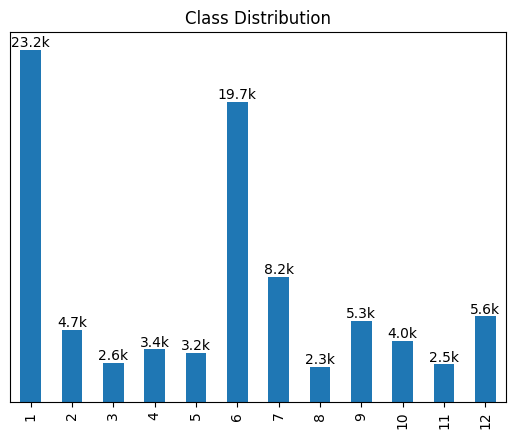

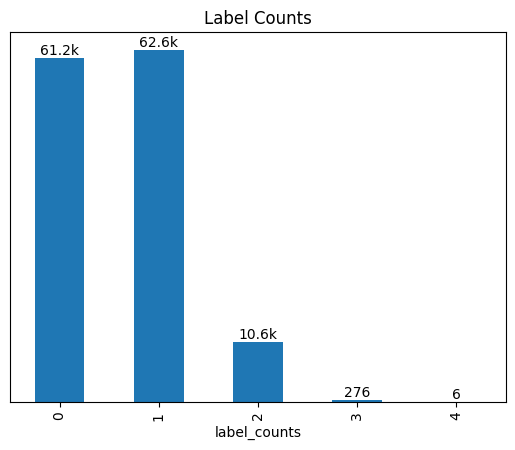



(134766, 15)


In [8]:
def preprocess(df, train_mode=False):
    if train_mode:
        print("Training preprocess")
        df = remove_too_long_text(df, max_length=MAX_COMMENT_LENGTH)

        df["label_counts"] = df[df.columns[2:]].sum(axis=1)
        df = upsampling_classes(df)
        df = downsampling_class_1_only(df)
        df = downsampling_class_6_only(df)
        df = downsampling_0_label(df)
        df = upsampling_2_label(df)

    # df["comment"] = df["comment"].apply(replace_url)
    # df["comment"] = df["comment"].apply(replace_rep)
    # df["comment"] = df["comment"].apply(remove_emojis)
    # df["comment"] = df["comment"].apply(remove_thai_endings)
    # df["comment"] = df["comment"].apply(
    # lambda x: x.translate(str.maketrans("", "", string.punctuation))
    # )

    return df


if PREPROCESS_DATA:
    print("======== Preprocess data ========")
    # df2 = df.copy()
    df = preprocess(df, train_mode=True)
    # df.to_csv("Preprocessed-data.csv", index=False)
    plot_class_distribution(df[df.columns[:-1]], "preprocessed_class_dist.png")
    plot_label_counts(df, "preprocessed_label_counts.png")
    print(df.shape)
    del df["label_counts"]

### Zip labels

In [9]:
df["label_counts"] = df[df.columns[2:]].sum(axis=1)
df["labels"] = df[df.columns[2:-1]].values.tolist()
df = df[["comment", "label_counts", "labels"]]

In [10]:
# train_df, eval_df = train_test_split(
#     df,
#     test_size=0.2,
#     stratify=df["label_counts"],
#     random_state=42,
# )

X = df["comment"].values
Y = np.array(df["labels"].tolist())

stratifier = IterativeStratification(
    n_splits=2, order=1, sample_distribution_per_fold=[0.2, 0.8]
)

train_indices, eval_indices = next(stratifier.split(X, Y))

train_df = df.iloc[train_indices].reset_index(drop=True)
eval_df = df.iloc[eval_indices].reset_index(drop=True)

print(train_df.describe())
print(eval_df.describe())

        label_counts
count  107812.000000
mean        0.628362
std         0.654950
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         4.000000
       label_counts
count  26954.000000
mean       0.628367
std        0.549294
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        4.000000


In [11]:
train_df

,comment,label_counts,labels
0,บริเวณนราธิวาส แยกถนนจันทน์ ใกล้สวนสาธารณะช่อ...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,บริเวณสะพานสามถนนจันทน์ เป็นจุดเปลี่ยนถ่ายสองแ...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,เรื่องทางม้าลายหายไป บริเวณสี่แยกถนนจันทร์-เซน...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,1. ซ่อมสายไฟ กรีดขวางทางเท้า,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,น้ำในคลองเน่าเหม็นมากครับ,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...
107807,-เปิดจำหน่ายสุราและเบียร์ โดยไม่มีใบอนุญาติ \n...,2,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
107808,ฝากซ่อมแซมด้วยครับ\n\nจากสภาพ พอเดาได้ว่าเกิด...,2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]"
107809,ถนนทางขึ้นสะพานแย่มากๆ ทั้ง2ฝั่ง ยังไม่มีใครมา...,2,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
107810,แถวเซเว่นปากซอยปรีดี 46 สายไฟ/สายสัญญาณ ห้อยเย...,2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]"


In [12]:
eval_df

,comment,label_counts,labels
0,พบรถแท็กซี่จอดทิ้งไว้บริเวณถนนถึงสัญญาณไฟช่วงแ...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,ป้อมตำรวจตรงแยกมิสทีนของเขตสะพานสูงขวางทางเท้า...,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,ใช่ค่ะ เมื่อวานโดนกับตัวเลยค่ะ รถเกือบล้ม ที่ถ...,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
3,ไฟจราจรสีแดงไม่ทำงาน (แต่สีเขียวทำ) ที่แยกถนนท...,1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
4,มีปัญหา\nเรื่องต้นไม้ที่เลื้อยพัน\nสายไฟฟ้า จะ...,2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]"
...,...,...,...
26949,Thank you for a job well done.\nThe klong walk...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
26950,Parking warden whistles\n\nI realise that thes...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
26951,การจัดงานลอยกระทงริมคลองผดุงกรุงเกษมทำให้ไม่สา...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
26952,ต่างด้าวและผู้มีอิทธิพล ตั้งวงดื่นสุราและมั่วส...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


### Define train classes

In [13]:
!wandb login API_KEY
wandb.init(project='datasci-midterm', name="hee")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: chanatip-kowsurat (chanatip-kowsurat-chulalongkorn-university). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250311_132841-uyrgqxy0
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run hee
wandb: ⭐️ View project at https://wandb.ai/chanatip-kowsurat-chulalongkorn-university/datasci-midterm
wandb: 🚀 View run at https://wandb.ai/chanatip-kowsurat-chulalongkorn-university/datasci-midterm/runs/uyrgqxy0


In [14]:
class HuggingFaceDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        input_ids = torch.tensor(item["input_ids"])
        attention_mask = torch.tensor(item["attention_mask"])
        if "label" in item:
            label = torch.tensor(item["label"], dtype=torch.float)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": label,
        }


# LightningModule for classification
class BertClassifier(pl.LightningModule):
    def __init__(self, model_name, num_labels, learning_rate=LEARNING_RATE):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels, problem_type="multi_label_classification"
        )
        self.learning_rate = learning_rate
        self.train_losses = []
        self.val_losses = []
        self.val_accuracy = []
        self.val_f1 = []

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids, attention_mask=attention_mask, labels=labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["label"],
        )
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=False)

        wandb.log({"train_loss": loss.item()}, commit=True)

        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["label"],
        )
        val_loss = outputs.loss
        preds = (torch.sigmoid(outputs.logits) > 0.5).int()
        y_true = batch["label"].cpu().numpy()
        y_pred = preds.cpu().numpy()
        val_acc = accuracy_score(y_true, y_pred)
        val_f1 = f1_score(y_true, y_pred, average="macro")

        self.log("val_loss", val_loss, prog_bar=True, on_epoch=True)
        self.log("val_f1", val_f1, prog_bar=True, on_epoch=True)
        self.log("val_acc", val_acc, prog_bar=True, on_epoch=True)

        wandb.log(
            {"val_loss": val_loss.item(), "val_f1": val_f1, "val_acc": val_acc},
            commit=True,
        )
        self.val_losses.append(val_loss.item())
        self.val_accuracy.append(val_acc)
        self.val_f1.append(val_f1)
        return val_loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

In [15]:
checkpoint = "clicknext/phayathaibert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_dataset(dataset):
    encoded = tokenizer(
        dataset["comment"],
        padding="max_length",
        max_length=TOKENIZER_MAX_LENGTH,
        truncation=True,
    )

    encoded["label"] = np.array(dataset["labels"])

    return encoded


train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

tokenized_train_dataset = train_dataset.map(tokenize_dataset, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_dataset, batched=True)

train_dataset = HuggingFaceDataset(tokenized_train_dataset)
eval_dataset = HuggingFaceDataset(tokenized_eval_dataset)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

Map:   0%|          | 0/107812 [00:00<?, ? examples/s]

Map:   0%|          | 0/26954 [00:00<?, ? examples/s]

### Train model

In [16]:
# Initialize the model
checkpoint = "clicknext/phayathaibert"
model = BertClassifier(model_name=checkpoint, num_labels=12)

wandb_logger = WandbLogger(project="datasci")

checkpoint_callback = ModelCheckpoint(
    monitor="val_f1",
    mode="max",
    save_top_k=3,
    filename="bert-{epoch:02d}-{val_f1:.3f}",
    save_weights_only=True,
)

# Update Trainer to use the callback
trainer = pl.Trainer(
    max_epochs=EPOCH,
    accelerator="gpu",
    devices=2,
    callbacks=[checkpoint_callback],
    logger=wandb_logger,
)

# Train the model
trainer.fit(model, train_loader, val_loader)
wandb.finish()

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at clicknext/phayathaibert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: ----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁
wandb:          train_loss █▃▃▄▂▂▄▂▂▂▂▂▃▂▃▁▃▂▃▁▂▃▂▁▂▂▂▁▁▃▁▂▃▂▃▂▂▂▂▂
wandb: trainer/global_step ▁▁
wandb:             val_acc ▄▃▂▁▂▃▅▃▂▂▅▅▄▅▅▂▃▆▂▅▆▇▆▆▅▇▇▇▇▇▆▇█▆▇▅▇▆▆█
wandb:              val_f1 ▅▄▅▅▄▆▅▅▃▆▇▅▆█▇▅▆▄▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃
wandb:            val_loss █▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
wandb: 
wandb: Run summary:
wandb:               epoch 0
wandb:          train_loss 0.08171
wandb: trainer/global_step 1684
wandb:             val_acc 1
wandb:              val_f1 0.08333
wandb:            val_loss 0.00915
wandb: 
wandb: 🚀 View run hee at: https://wandb.ai/chanatip-kowsurat-chulalongkorn-university/datasci-midterm/runs/uyrgqxy0
wandb: ⭐️ View project at: https://wandb.ai/chanatip-kowsurat-chulalongkorn-university/datasci-midterm
wandb: Synced 5 W&B file(s), 0 media file(s), 0 ar

### Model Predictions

#### Create test classes

In [17]:
class HuggingFaceTestDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        input_ids = torch.tensor(item["input_ids"])
        attention_mask = torch.tensor(item["attention_mask"])

        # label = torch.tensor(item["label"], dtype=torch.float)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
        }


def tokenize_test_dataset(dataset):
    encoded = tokenizer(
        dataset["comment"],
        padding="max_length",
        max_length=128,
        truncation=True,
    )
    return encoded

#### Load test dataset

In [18]:
test_data = pd.read_csv(dataset_path + "test.csv")
print(test_data.shape)
print(test_data.head())
if PREPROCESS_DATA:
    print("Preprocess test data")
    test_data = preprocess(test_data)
    print(test_data.iloc[202]["comment"][150:])

test_dataset = Dataset.from_pandas(test_data)
tokenized_test_dataset = test_dataset.map(tokenize_test_dataset)

test_dataset = HuggingFaceTestDataset(tokenized_test_dataset)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

(10810, 2)
   id                                            comment
0   0  ไม่มีทางเท้าคนเดินจากสะพานกรุงธนบุรีไปวัดราชผา...
1   1  อันนี้ภาพทางเข้าถ่ายไว้นานแล้วค่ะ ในซอยถนนจะเป...
2   2                                 ขยะที่แยกสะพานควาย
3   3  ช่วงเร่งคืนพื้นที่ช่องจราจรถนนแจ้งวัฒนะ ช่วงวิ...
4   4  - ไฟถนนไม่ติด เป็นทางยาว คนเดินถนนลำบากมาก ถนน...
Preprocess test data
กิดความอันตรายทั้งรถและคน

ตำแหน่ง : https://goo.gl/maps/3C5hqb41uRLP71xJA


Map:   0%|          | 0/10810 [00:00<?, ? examples/s]

In [19]:
test_data.head()

,id,comment
0,0,ไม่มีทางเท้าคนเดินจากสะพานกรุงธนบุรีไปวัดราชผา...
1,1,อันนี้ภาพทางเข้าถ่ายไว้นานแล้วค่ะ ในซอยถนนจะเป...
2,2,ขยะที่แยกสะพานควาย
3,3,ช่วงเร่งคืนพื้นที่ช่องจราจรถนนแจ้งวัฒนะ ช่วงวิ...
4,4,- ไฟถนนไม่ติด เป็นทางยาว คนเดินถนนลำบากมาก ถนน...


#### Make predictions

In [20]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

classes = [
    "สำนักงานตำรวจแห่งชาติ",
    "การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย",
    "สภาเด็กและเยาวชนกรุงเทพมหานคร",
    "กรมควบคุมมลพิษ",
    "กรมสรรพสามิต",
    "การไฟฟ้านครหลวง",
    "กรมทางหลวง",
    "สำนักงานประกันสุขภาพแห่งชาติ",
    "การประปานครหลวง",
    "คณะกรรมการการพัฒนาเศรษฐกิจ",
    "กระทรวงการท่องเที่ยวและกีฬา",
    "สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200",
]


# Collect predictions
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        # predictions = torch.argmax(logits, dim=-1)
        probs = torch.sigmoid(logits)
        # predictions = (probs > 0.5).int()

        # print(probs)
        predictions = (probs >= PREDICTION_THRESHOLD).to(torch.int)

        predicted_labels.extend(predictions.cpu().numpy())


for label in classes:
    test_data[label] = 0

for i, pred in enumerate(predicted_labels):
    for j, label in enumerate(classes):
        # print(i, pred, label)
        test_data.at[i, label] = pred[j]

In [21]:
test_data.head()

,id,comment,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
0,0,ไม่มีทางเท้าคนเดินจากสะพานกรุงธนบุรีไปวัดราชผา...,0,0,0,0,0,0,0,0,0,0,0,0
1,1,อันนี้ภาพทางเข้าถ่ายไว้นานแล้วค่ะ ในซอยถนนจะเป...,0,0,0,0,0,0,0,0,0,0,0,0
2,2,ขยะที่แยกสะพานควาย,0,0,0,0,0,0,0,0,0,0,0,0
3,3,ช่วงเร่งคืนพื้นที่ช่องจราจรถนนแจ้งวัฒนะ ช่วงวิ...,1,0,0,0,0,0,0,0,0,0,0,0
4,4,- ไฟถนนไม่ติด เป็นทางยาว คนเดินถนนลำบากมาก ถนน...,0,0,0,0,0,0,0,0,0,0,0,0


#### Save results

In [22]:
test_data.describe()

,id,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
count,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000
mean,5404.500000,0.209991,0.015726,0.000278,0.025439,0.000093,0.133488,0.015079,0.001295,0.015541,0.018316,0.000370,0.022479
std,3120.722539,0.407320,0.124420,0.016657,0.157463,0.009618,0.340117,0.121871,0.035966,0.123697,0.134099,0.019233,0.148243
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2702.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5404.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8106.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10809.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
# test_data.to_csv("before_submission.csv", index=False)
del test_data["comment"]
test_data.to_csv("submission_05.csv", index=False)
print("******************** DONE ********************")

******************** DONE ********************


In [24]:
test_data.describe()

,id,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
count,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000,10810.000000
mean,5404.500000,0.209991,0.015726,0.000278,0.025439,0.000093,0.133488,0.015079,0.001295,0.015541,0.018316,0.000370,0.022479
std,3120.722539,0.407320,0.124420,0.016657,0.157463,0.009618,0.340117,0.121871,0.035966,0.123697,0.134099,0.019233,0.148243
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2702.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5404.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8106.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10809.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Result graphs

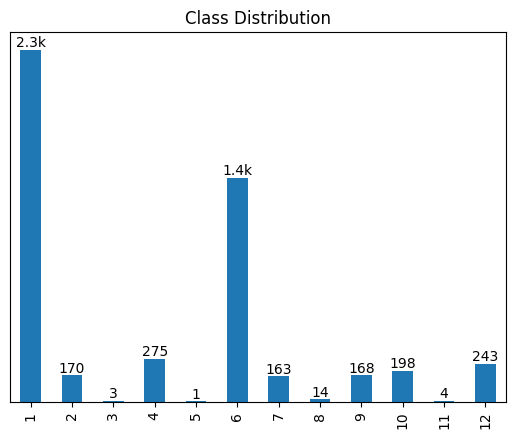

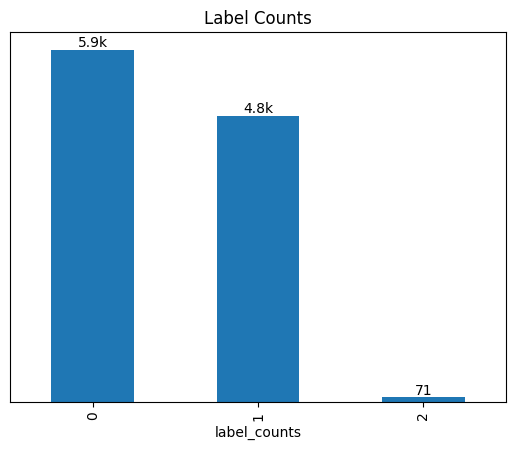

In [25]:
def plot_class_distribution(df, filename="class_dist.png"):
    label_counts = df.iloc[:, 1:].sum()
    label_counts.plot(kind="bar")
    for i, count in enumerate(label_counts):
        plt.text(
            i,
            count,
            f"{count if count < 1000 else f'{count/1000:.1f}k'}",
            ha="center",
            va="bottom",
        )
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.title("Class Distribution")
    plt.xticks(range(12), range(1, 13))
    plt.savefig(f"/kaggle/working/graphs/{filename}")
    plt.show()
    print("\n")
    return


plot_class_distribution(test_data, "predicted_class_dist_05.png")
test_data["label_counts"] = test_data[test_data.columns[1:]].sum(axis=1)
plot_label_counts(test_data, "predicted_test_data_05.png")

(10810, 2)
   id                                            comment
0   0  ไม่มีทางเท้าคนเดินจากสะพานกรุงธนบุรีไปวัดราชผา...
1   1  อันนี้ภาพทางเข้าถ่ายไว้นานแล้วค่ะ ในซอยถนนจะเป...
2   2                                 ขยะที่แยกสะพานควาย
3   3  ช่วงเร่งคืนพื้นที่ช่องจราจรถนนแจ้งวัฒนะ ช่วงวิ...
4   4  - ไฟถนนไม่ติด เป็นทางยาว คนเดินถนนลำบากมาก ถนน...
Preprocess test data
กิดความอันตรายทั้งรถและคน

ตำแหน่ง : https://goo.gl/maps/3C5hqb41uRLP71xJA


Map:   0%|          | 0/10810 [00:00<?, ? examples/s]

******************** DONE ********************


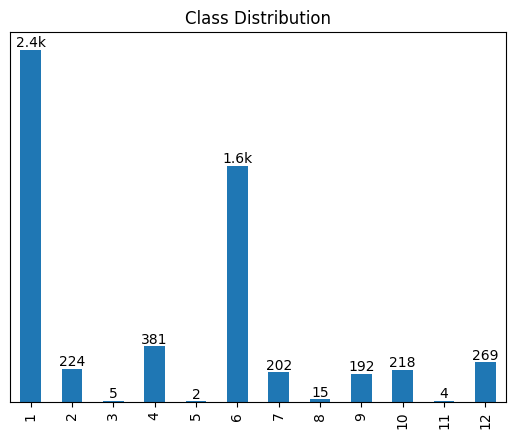

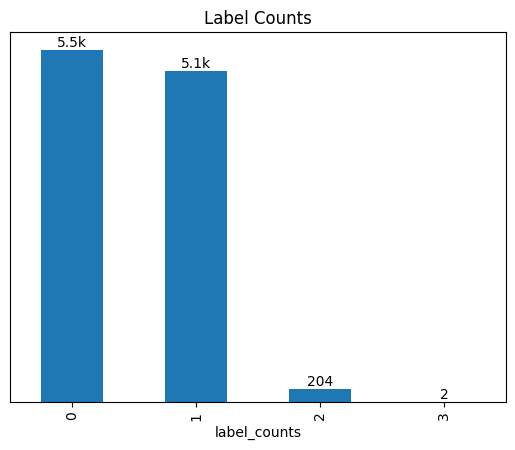

In [26]:
PREDICTION_THRESHOLD = 0.4

test_data = pd.read_csv(dataset_path + "test.csv")
print(test_data.shape)
print(test_data.head())
if PREPROCESS_DATA:
    print("Preprocess test data")
    test_data = preprocess(test_data)
    print(test_data.iloc[202]["comment"][150:])

test_dataset = Dataset.from_pandas(test_data)
tokenized_test_dataset = test_dataset.map(tokenize_test_dataset)

test_dataset = HuggingFaceTestDataset(tokenized_test_dataset)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        # predictions = torch.argmax(logits, dim=-1)
        probs = torch.sigmoid(logits)
        # predictions = (probs > 0.5).int()

        # print(probs)
        predictions = (probs >= PREDICTION_THRESHOLD).to(torch.int)

        predicted_labels.extend(predictions.cpu().numpy())


for label in classes:
    test_data[label] = 0

for i, pred in enumerate(predicted_labels):
    for j, label in enumerate(classes):
        # print(i, pred, label)
        test_data.at[i, label] = pred[j]

test_data.describe()
# test_data.to_csv("submission.csv", index=False)
# test_data.to_csv("before_submission.csv", index=False)
del test_data["comment"]
test_data.to_csv("submission_04.csv", index=False)
print("******************** DONE ********************")

plot_class_distribution(test_data, "predicted_class_dist_04.png")
test_data["label_counts"] = test_data[test_data.columns[1:]].sum(axis=1)
plot_label_counts(test_data, "predicted_test_data_04.png")